# Paddy disease classification
Kaggle competition
https://www.kaggle.com/competitions/paddy-disease-classification

### Setting up env and downloading data from kaggle

In [1]:
import os

if os.getenv("COLAB_RELEASE_TAG"):
  colab_flag = True
else:
  colab_flag = False

if colab_flag == True:
   print("Running in Colab...")
   #Install Kaggle API
   ! pip install -q kaggle
   #Install Huggingface Datasets lib
   ! pip install -q datasets
   #Install Huggingface transformers & the sentencepiece
   ! pip install -q transformers[sentencepiece,torch]
   #Intall Timm for Pytorch Image Models
   ! pip install -q timm
   print("...Installed required dependencies")
else:
   print("Assuming running in local environment...")

Assuming running in local environment...


In [2]:
if colab_flag == True:
  import json
  from google.colab import drive
  drive.mount('/content/drive/')

  # Set the file path
  file_path = '/content/drive/MyDrive/dtu/fastAI/04_NLP/kaggle_api.json'

  # Check if the file exists
  if os.path.exists(file_path):
      # Load the JSON file
      with open(file_path) as f:
          creds = json.load(f)
      print('Sucesfully set kaggle credentials')
  else:
      # Handle the case when the file does not exist
      creds = None  # or any other appropriate action you want to take
      print('Error: File not found, Credentials NOT set')
else:
    import json
    file_path = "../secrets/kaggle_api.json"
    # Check if the file exists
    if os.path.exists(file_path):
        # Load the JSON file
        with open(file_path) as f:
            creds = json.load(f)
        print('Sucesfully set kaggle credentials')
    else:
        # Handle the case when the file does not exist
        creds = None  # or any other appropriate action you want to take
        print('Error: File not found, Credentials NOT set')

Sucesfully set kaggle credentials


In [3]:
#using `pathlib.Path to work with paths in Python`
from pathlib import Path
#Set path for the titanic dataset
path = Path('paddy-disease-classification')

if path.exists():
  print('Data folder exists')
else:
  print('Data not detected, starting download')
  #Setup of kaggle credentials to use the API for downloading dataset
  cred_path = Path('~/.kaggle/kaggle.json').expanduser()
  if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(json.dumps(creds))
    #If not Json
    #cred_path.write_text(creds)
    cred_path.chmod(0o600)
  import zipfile,kaggle
  #Download data
  kaggle.api.competition_download_cli(str(path))
  #Unzip at path
  zipfile.ZipFile(f'{path}.zip').extractall(path)

#Verifying the the local content
!ls {path}

Data folder exists
sample_submission.csv  test_images  train.csv  train_images


### Inspecting the data

In [4]:
from fastai.vision.all import *
set_seed(42)

train_path = path/'train_images'
files = get_image_files(train_path)

In [5]:
#Simply contains the filename of all the images in the given folder
files[0:3]

(#3) [Path('paddy-disease-classification/train_images/bacterial_leaf_streak/104135.jpg'),Path('paddy-disease-classification/train_images/bacterial_leaf_streak/100701.jpg'),Path('paddy-disease-classification/train_images/bacterial_leaf_streak/105386.jpg')]

### WARNING! Image size: 480x640 or 640x480 ??
Images need to be resized to same dimension for the ML model to process.


**OBS for dimensions!!** If you request different library you might get different response.
- In "image world" (PIL), Columns by Rows (if using img.size, .shape will return rows by columns)
- Pytorch, returns Rows by Columns

Size according to PIL image: (480, 640)
Shape according to PIL image: (640, 480)
Shape according to torch, tensor: torch.Size([640, 480, 3])


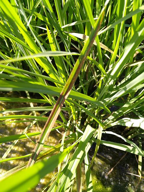

In [6]:
img = PILImage.create(files[5])
print(f'Size according to PIL image: {img.size}')
print(f'Shape according to PIL image: {img.shape}')
#Convert to tensor
img_t = tensor(img)
print(f'Shape according to torch, tensor: {img_t.shape}')
img.to_thumb(192)

Checking the image size is suprisingly slow process, hence we do it in parallel to speed up.

In [7]:
import multiprocessing

n_cores = multiprocessing.cpu_count()

In [8]:
from fastcore.parallel import *

def check_size(img):
    return PILImage.create(img).size

sizes = parallel(check_size, files, n_workers=n_cores)
pd.Series(sizes).value_counts()

(480, 640)    10403
(640, 480)        4
Name: count, dtype: int64

Observing that a few are out of size, hence we have to resize our images.

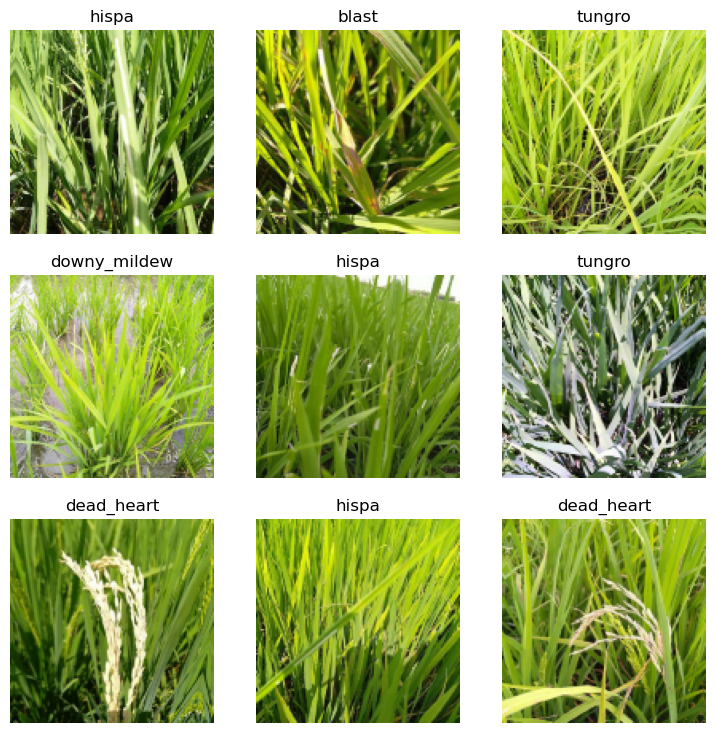

In [12]:
dls = ImageDataLoaders.from_folder(train_path,
                                        valid_pct=0.2,
                                        seed=42,
                                        item_transform=Resize(480, method='squish'),
                                        #Data augmentation done on GPU, transformations of the data taking
                                        #a subset of the image (128) and applying random transformations
                                        batch_tfms=aug_transforms(size=128, min_scale=0.75))

dls.show_batch()

### The first model
Best models for finetuning, 100 different models, evaluated on the Pets dataset and a sattelite imagedataset (Planet): https://www.kaggle.com/code/jhoward/the-best-vision-models-for-fine-tuning . **One year old**

To begin with, choose decent accuracy but FAST model = Resnet26d

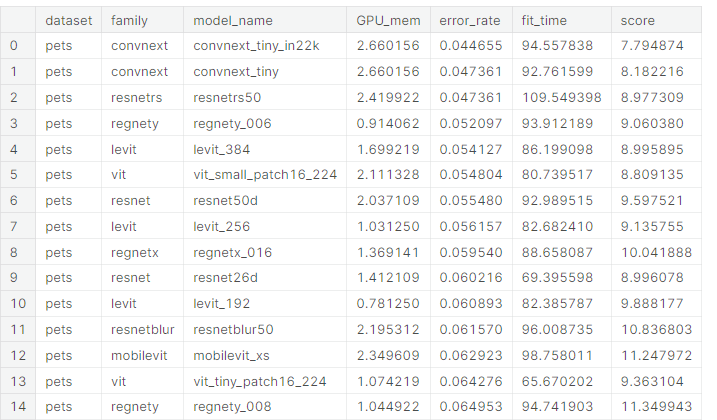

In [13]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.').to_fp16()

In [14]:
learn.lr_find(suggest_funcs=(valley, slide))

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/jealk/mambaforge/envs/fastai/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/jealk/mambaforge/envs/fastai/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 41, in fetch
    data = next(self.dataset_iter)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jealk/mambaforge/envs/fastai/lib/python3.11/site-packages/fastai/data/load.py", line 138, in create_batches
    yield from map(self.do_batch, self.chunkify(res))
  File "/home/jealk/mambaforge/envs/fastai/lib/python3.11/site-packages/fastai/data/load.py", line 168, in do_batch
    def do_batch(self, b): return self.retain(self.create_batch(self.before_batch(b)), b)
                                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jealk/mambaforge/envs/fastai/lib/python3.11/site-packages/fastai/data/load.py", line 166, in create_batch
    if not self.prebatched: collate_error(e,b)
                            ^^^^^^^^^^^^^^^^^^
  File "/home/jealk/mambaforge/envs/fastai/lib/python3.11/site-packages/fastai/data/load.py", line 164, in create_batch
    try: return (fa_collate,fa_convert)[self.prebatched](b)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jealk/mambaforge/envs/fastai/lib/python3.11/site-packages/fastai/data/load.py", line 52, in fa_collate
    else type(t[0])([fa_collate(s) for s in zip(*t)]) if isinstance(b, Sequence)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jealk/mambaforge/envs/fastai/lib/python3.11/site-packages/fastai/data/load.py", line 52, in <listcomp>
    else type(t[0])([fa_collate(s) for s in zip(*t)]) if isinstance(b, Sequence)
                     ^^^^^^^^^^^^^
  File "/home/jealk/mambaforge/envs/fastai/lib/python3.11/site-packages/fastai/data/load.py", line 51, in fa_collate
    return (default_collate(t) if isinstance(b, _collate_types)
            ^^^^^^^^^^^^^^^^^^
  File "/home/jealk/mambaforge/envs/fastai/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py", line 265, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jealk/mambaforge/envs/fastai/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py", line 123, in collate
    return collate_fn_map[collate_type](batch, collate_fn_map=collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jealk/mambaforge/envs/fastai/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py", line 162, in collate_tensor_fn
    return torch.stack(batch, 0, out=out)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jealk/mambaforge/envs/fastai/lib/python3.11/site-packages/fastai/torch_core.py", line 382, in __torch_function__
    res = super().__torch_function__(func, types, args, ifnone(kwargs, {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jealk/mambaforge/envs/fastai/lib/python3.11/site-packages/torch/_tensor.py", line 1295, in __torch_function__
    ret = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
RuntimeError: Error when trying to collate the data into batches with fa_collate, at least two tensors in the batch are not the same size.

Mismatch found on axis 0 of the batch and is of type `TensorImage`:
	Item at index 0 has shape: torch.Size([3, 640, 480])
	Item at index 4 has shape: torch.Size([3, 480, 640])

Please include a transform in `after_item` that ensures all data of type TensorImage is the same size
